In [11]:
from torch_snippets import *
import torch.nn as nn
from torchvision import transforms as T
from torch.nn import functional as F
from torchvision.models import vgg19
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Style Transfer

In [222]:

preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x.mul_(255))
])


preprocess_style = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x.mul_(255))
])


postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1.0/255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                std=[1/0.229,1/0.224,1/0.225]),
])

In [223]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        feature = input.view(b, c, h*w)
        G = feature @ feature.transpose(1,2)
        G.div_(h*w)
        return G

In [224]:
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)

In [225]:
features = list(vgg19(pretrained=True).features)

In [226]:
features[:5]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]

In [227]:
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained=True).features)
        self.features = nn.ModuleList(features).eval()
    
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix, model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x

In [228]:
vgg = vgg19_modified().to(device)

In [286]:
imgs = [Image.open(path).resize((512,512)).convert("RGB")\
        for path in ["pics/style8.png","pics/parmy.jpg"]]
style_image,content_image=[preprocess(img).to(device)[None] \
 for img in imgs]
#style_image = preprocess_style(imgs[0]).to(device)[None]
#content_image = preprocess(imgs[1]).to(device)[None]


In [287]:
style_image.shape

torch.Size([1, 3, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


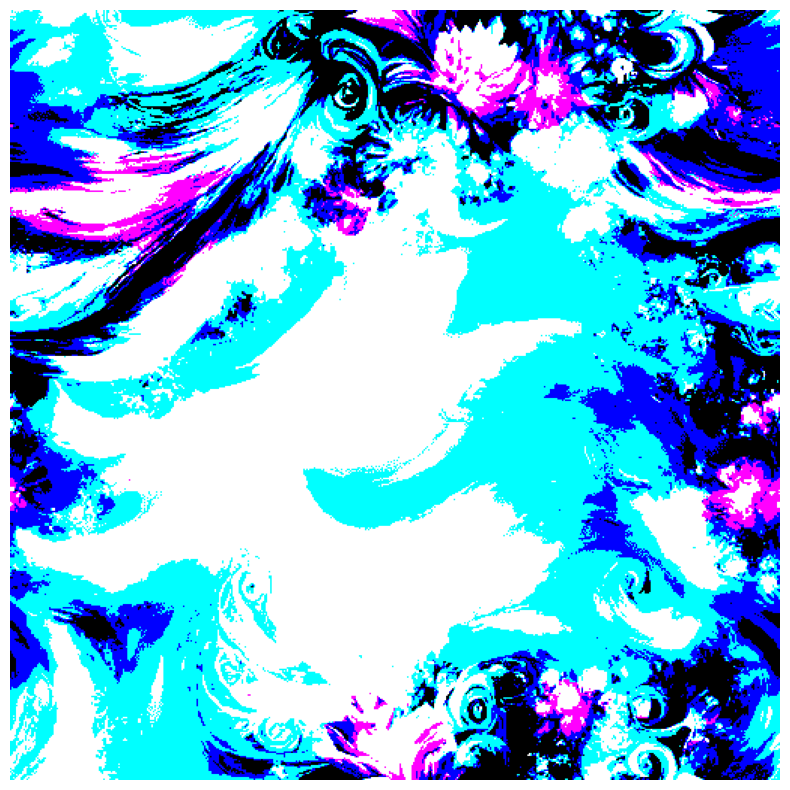

In [288]:
show(style_image.squeeze().permute(1,2,0).cpu())

In [289]:
opt_img = content_image.data.clone()
opt_img.requires_grad=True

In [290]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]
loss_layers = style_layers + content_layers

In [291]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [292]:
style_weights = [1000/n**2 for n in [64,128,256,512,512]]
content_weights = [1]
weights = style_weights + content_weights


In [293]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image,style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [294]:
max_iters = 500
optimizer = optim.LBFGS([opt_img])
log = Report(max_iters)

In [295]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img,loss_layers)
        layer_losses = [weights[a]*loss_fns[a](A,targets[a]) \
                        for a, A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        log.record(pos=iters, loss=loss, end='\r')
        return loss
    optimizer.step(closure)

EPOCH: 500.000  loss: 207141.281  (15.58s - 0.00s remaining)))

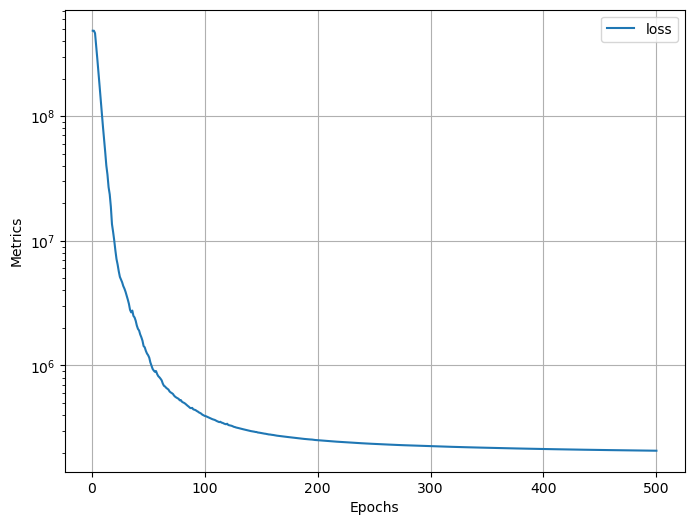

In [296]:
log.plot(log=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


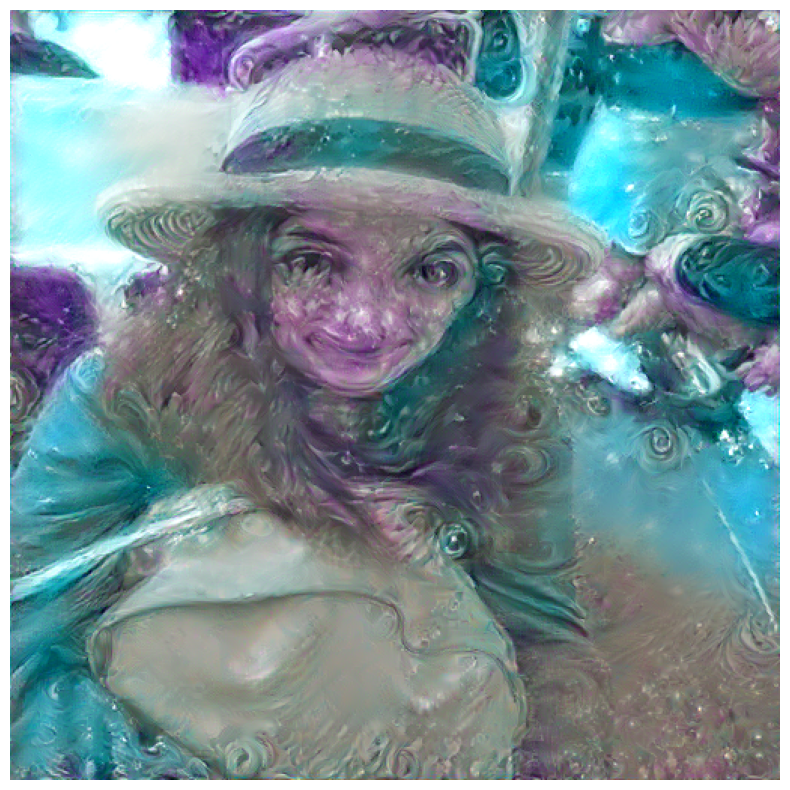

In [297]:
with torch.no_grad():
    out_img2 = postprocess(opt_img[0]).permute(1,2,0)
show(out_img2)